In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import joblib
from time import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

from scipy.optimize import curve_fit
import scipy.optimize

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

# NN dependencies
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import gpytorch
from botorch.utils.transforms import normalize, unnormalize


from CBFV.composition import generate_features
from torch.optim.lr_scheduler import ReduceLROnPlateau

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

C:\Users\lowki\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lowki\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lowki\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Data stuff

In [18]:
df = pd.read_csv('zt_starryData2.csv')
df

,formula,Temperature,zt
0,Mn34.6W1.8Si63.6,350,0.127878
1,Mn34.6W1.8Si63.6,400,0.174548
2,Mn34.6W1.8Si63.6,450,0.223062
3,Mn34.6W1.8Si63.6,500,0.272720
4,Mn34.6W1.8Si63.6,550,0.325687
...,...,...,...
18121,ZrNiSn,900,0.449585
18122,ZrNiSn,950,0.443848
18123,ZrNiSn0.94Sb0.06,400,0.046900
18124,ZrNiSn0.94Sb0.06,450,0.045813


In [19]:
badtemp_idx = []
# remove datapoints when ZT readings are so miniscule
for i in df.index:
    if df.loc[i]['zt'] < 1e-1:
        df = df.drop(i)
        
# remove compounds with 2 or less readings
for i in df.index:
    currentcompound = df.loc[i]['formula']
    if len(df[df['formula'] == currentcompound]) < 3:
        df = df.drop(i)
        
df

,formula,Temperature,zt
0,Mn34.6W1.8Si63.6,350,0.127878
1,Mn34.6W1.8Si63.6,400,0.174548
2,Mn34.6W1.8Si63.6,450,0.223062
3,Mn34.6W1.8Si63.6,500,0.272720
4,Mn34.6W1.8Si63.6,550,0.325687
...,...,...,...
18118,ZrNiSn,750,0.650337
18119,ZrNiSn,800,0.717378
18120,ZrNiSn,850,0.445718
18121,ZrNiSn,900,0.449585


In [20]:
sussyformula = []

sussyidx1 = []
sussyidx2 = []

# we first filter out sussy compounds which have datapoints beyond the 300-800K window
# if they have sufficient overlap into the window (100K past the min/max, so 400-700K), we accept

for i in df.index:
    if df.loc[i]['Temperature'] < 300:
        sussyidx1.append(i)
        
for i in df.index:
    if df.loc[i]['Temperature'] > 800:
        sussyidx2.append(i)

for formula in df.loc[sussyidx1].drop_duplicates(subset=['formula'])['formula']:
    dftemp = df[df['formula'] == formula]
    if dftemp['Temperature'].max() < 400:
        sussyformula.append(formula)
        
for formula in df.loc[sussyidx2].drop_duplicates(subset=['formula'])['formula']:
    dftemp = df[df['formula'] == formula]
    if dftemp['Temperature'].min() > 700:
        sussyformula.append(formula)
        
for formula in sussyformula:
    idx = df[df['formula'] == formula].index
    df = df.drop(idx)
    
df

,formula,Temperature,zt
0,Mn34.6W1.8Si63.6,350,0.127878
1,Mn34.6W1.8Si63.6,400,0.174548
2,Mn34.6W1.8Si63.6,450,0.223062
3,Mn34.6W1.8Si63.6,500,0.272720
4,Mn34.6W1.8Si63.6,550,0.325687
...,...,...,...
18118,ZrNiSn,750,0.650337
18119,ZrNiSn,800,0.717378
18120,ZrNiSn,850,0.445718
18121,ZrNiSn,900,0.449585


<AxesSubplot:ylabel='Frequency'>

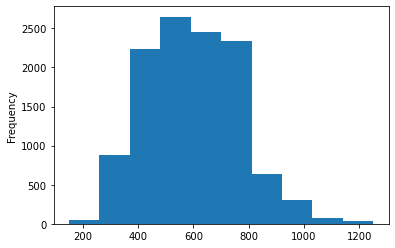

In [21]:
df['Temperature'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

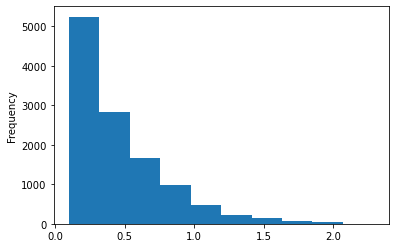

In [22]:
df['zt'].plot.hist()

In [23]:
tempscaler = StandardScaler()
df['temp_new'] = tempscaler.fit_transform(df['Temperature'].to_numpy().reshape(-1, 1))
ztscaler = PowerTransformer(method='box-cox')
df['zt_new'] = ztscaler.fit_transform(df['zt'].to_numpy().reshape(-1, 1))

df

,formula,Temperature,zt,temp_new,zt_new
0,Mn34.6W1.8Si63.6,350,0.127878,-1.458564,-1.559114
1,Mn34.6W1.8Si63.6,400,0.174548,-1.156442,-1.064567
2,Mn34.6W1.8Si63.6,450,0.223062,-0.854320,-0.685284
3,Mn34.6W1.8Si63.6,500,0.272720,-0.552199,-0.381219
4,Mn34.6W1.8Si63.6,550,0.325687,-0.250077,-0.117681
...,...,...,...,...,...
18118,ZrNiSn,750,0.650337,0.958411,0.866211
18119,ZrNiSn,800,0.717378,1.260533,1.000437
18120,ZrNiSn,850,0.445718,1.562655,0.337031
18121,ZrNiSn,900,0.449585,1.864777,0.349351


<AxesSubplot:ylabel='Frequency'>

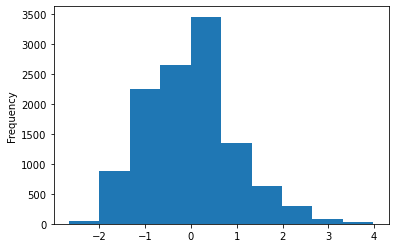

In [24]:
df['temp_new'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

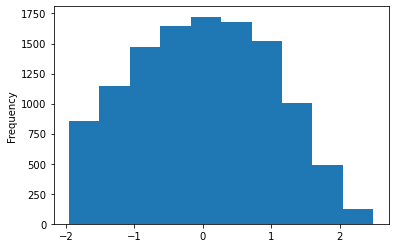

In [25]:
df['zt_new'].plot.hist()

In [26]:
unique_filtered = df.drop_duplicates(subset=['formula'])['formula']
unique_filtered

0          Mn34.6W1.8Si63.6
9                Pb5Bi6Se14
30               Ag0.005CdO
38               Ag0.02TiS2
45             Ag0.02Zn4Sb3
                ...        
18066      Zr3Ni2.7Co0.3Sb4
18076      Zr3Ni2.8Co0.2Sb4
18087             ZrNi1.1Sn
18100    ZrNiPb0.993Bi0.007
18111                ZrNiSn
Name: formula, Length: 1626, dtype: object

In [27]:
# look at good and bad examples

sussy_idx = []

for i in unique_filtered.index:
    if len(df.loc[df['formula'] == unique_filtered[i]]) == 3:
        sussy_idx.append(i)
        
nonsussy_idx = []

for i in unique_filtered.index:
    if len(df.loc[df['formula'] == unique_filtered[i]]) >= 5:
        nonsussy_idx.append(i)

In [29]:
class Magic():
    def __init__(self):
        self.coeff = None
        # [a, m ,q,
        #  k, p]
        
        self.lowerbound = [-3, -5, -5,
                           -1.5, 1e-2]
        
        self.upperbound = [3, 5, 5,
                           1.5, 1.5]
        
        self.starting = [0, 0, 0, 
                         0.1, 1e-2]
    
    def log_decay(self, x, a, m, q, k, p):
        
        # sigmoid function forms the basis of the curve
        # exponential decay helps model flatness and slight drop off
        # parabola models sharper ZT-T peaks in a narrow T range
        
        # we set a, k, and b to smaller coeffs to deal with very small ZT (<0.01)
        # we limit b and c to prevent overflow numbers to NaN
        
        
        # coordinate coefficients [-5, 5]
        # a - upper asymptote of sigmoid
        # m - midpoint of sigmoid
        # n - start of decay
        # q - peak of parabola
        
        # gradient coefficients []
        # k - gradient of sigmoid
        # b - main factor for decay
        # c - sub factor for decay
        # p - main factor for parabola
        
        
        # we add a gating function within the exponential and power terms to prevent overflow
        func1 = a / (1 + np.exp(-k*(x-m)))
        func2 = -p*np.power(x-q,2)

        return np.clip(func1 + func2, -4, 4)

    def train(self, x, y):
        
        popt, pcov = curve_fit(self.log_decay, x, y, p0=self.starting, 
                               method='trf',
                               bounds=(self.lowerbound,self.upperbound),
                               maxfev=1e5)
        
        self.coeff = popt
        
    def predict(self, x):
        
        return self.log_decay(x, *self.coeff)

Text(0, 0.5, 'ZT')

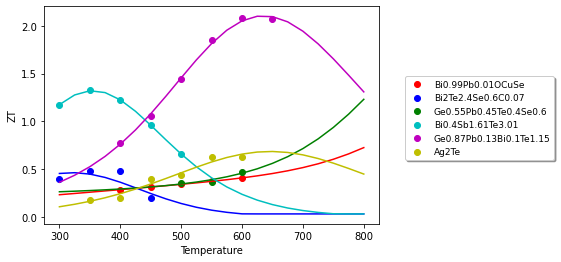

In [30]:
# a few preliminary testing for ZT-T approximation

naughty_compounds = ['Bi0.99Pb0.01OCuSe', 'Bi2Te2.4Se0.6C0.07', 'Ge0.55Pb0.45Te0.4Se0.6', 'Bi0.4Sb1.61Te3.01',
                     'Ge0.87Pb0.13Bi0.1Te1.15', 'Ag2Te']

for compound, c in zip(naughty_compounds,
                       ['r', 'b', 'g', 'c', 'm', 'y']):

    df_temp = df.loc[df['formula'] == compound]

    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    test_X = tempscaler.transform(np.linspace(300, 800, int((800-300)/25)+1).reshape(-1, 1))
    
    magic = Magic()
    magic.train(temp_X, temp_y)
    test_y = magic.predict(test_X)

    temp_y = ztscaler.inverse_transform(temp_y.reshape(-1, 1))
    test_y = ztscaler.inverse_transform(test_y.reshape(-1, 1))
    
    temp_X = tempscaler.inverse_transform(temp_X.reshape(-1, 1))
    test_X = tempscaler.inverse_transform(test_X.reshape(-1, 1))

    plt.plot(test_X, test_y, c=c)

    plt.scatter(temp_X, temp_y, label=f"{compound}", c=c)
    
        
    if np.isnan(test_y).sum() > 0:
        print(f"Compound {compound} with index {n} is problematic!")

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.7), fontsize=9,
          ncol=1, fancybox=True, shadow=True)
plt.xlabel("Temperature")
plt.ylabel("ZT")

Text(0, 0.5, 'ZT')

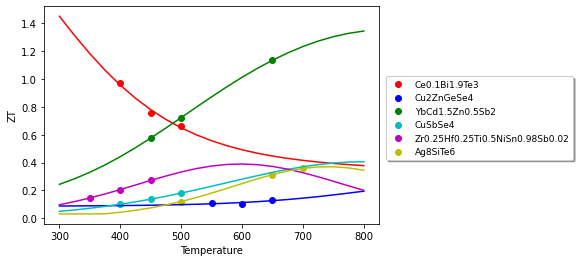

In [31]:
# a few preliminary testing for ZT-T approximation

random_num = np.random.choice(sussy_idx, 6)
random_names = unique_filtered[random_num]

for n, c in zip(random_num, ['r', 'b', 'g', 'c', 'm', 'y']):

    df_temp = df.loc[df['formula'] == unique_filtered[n]]

    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    test_X = tempscaler.transform(np.linspace(300, 800, int((800-300)/25)+1).reshape(-1, 1))
    
    magic = Magic()
    magic.train(temp_X, temp_y)
    test_y = magic.predict(test_X)

    temp_y = ztscaler.inverse_transform(temp_y.reshape(-1, 1))
    test_y = ztscaler.inverse_transform(test_y.reshape(-1, 1))
    
    temp_X = tempscaler.inverse_transform(temp_X.reshape(-1, 1))
    test_X = tempscaler.inverse_transform(test_X.reshape(-1, 1))

    plt.plot(test_X, test_y, c=c)

    plt.scatter(temp_X, temp_y, label=f"{unique_filtered[n]}", c=c)
    
        
    if np.isnan(test_y).sum() > 0:
        print(f"Compound {unique_filtered[n]} with index {n} is problematic!")

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.7), fontsize=9,
          ncol=1, fancybox=True, shadow=True)
plt.xlabel("Temperature")
plt.ylabel("ZT")

Text(0, 0.5, 'ZT')

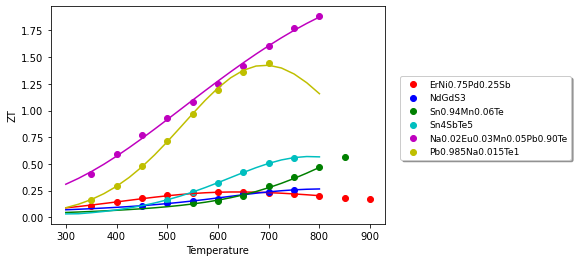

In [15]:
# a few preliminary testing for ZT-T approximation

random_num = np.random.choice(nonsussy_idx, 6)
random_names = unique_filtered[random_num]

for n, c in zip(random_num, ['r', 'b', 'g', 'c', 'm', 'y']):

    df_temp = df.loc[df['formula'] == unique_filtered[n]]

    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    test_X = tempscaler.transform(np.linspace(300, 800, int((800-300)/25)+1).reshape(-1, 1))
    
    magic = Magic()
    magic.train(temp_X, temp_y)
    test_y = magic.predict(test_X)

    temp_y = ztscaler.inverse_transform(temp_y.reshape(-1, 1))
    test_y = ztscaler.inverse_transform(test_y.reshape(-1, 1))
    
    temp_X = tempscaler.inverse_transform(temp_X.reshape(-1, 1))
    test_X = tempscaler.inverse_transform(test_X.reshape(-1, 1))

    plt.plot(test_X, test_y, c=c)

    plt.scatter(temp_X, temp_y, label=f"{unique_filtered[n]}", c=c)
    
        
    if np.isnan(test_y).sum() > 0:
        print(f"Compound {unique_filtered[n]} with index {n} is problematic!")

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.7), fontsize=9,
          ncol=1, fancybox=True, shadow=True)
plt.xlabel("Temperature")
plt.ylabel("ZT")

In [32]:
df_everything = pd.DataFrame(columns=['a', 'm', 'q', 'k', 'p'])

for i, n in enumerate(unique_filtered.index):
    df_temp = df.loc[df['formula'] == unique_filtered[n]]
    
    temp_X = df_temp['temp_new'].to_numpy()
    temp_y = df_temp['zt_new'].to_numpy()
    
    magic = Magic()
    magic.train(temp_X, temp_y)
        
    df_everything.loc[i] = magic.coeff
    
    if i%100==0:
        print(f"{i}/{len(unique_filtered.index)}")
        
print("Done!")

0/1626
100/1626
200/1626
300/1626
400/1626
500/1626
600/1626
700/1626
800/1626
900/1626
1000/1626
1100/1626
1200/1626
1300/1626
1400/1626
1500/1626
1600/1626
Done!


In [33]:
df_everything

,a,m,q,k,p
0,1.031903,1.132629,1.199926,-0.001459,0.290124
1,1.761222,0.085656,1.969990,0.001161,0.351764
2,-0.333947,1.202546,2.752054,-1.500000,0.285028
3,1.276173,-0.740363,4.999992,1.500000,0.037586
4,2.999999,-0.496762,1.060717,-1.116143,0.461108
...,...,...,...,...,...
1621,-0.420420,-0.083484,1.187341,-0.001205,0.227364
1622,0.697107,0.975113,0.791262,1.500000,0.229938
1623,3.000000,0.834416,2.900146,-0.604342,0.211997
1624,1.146301,-0.783000,0.768947,0.000942,0.321004


In [34]:
unique_filtered.to_csv(f"19sep_compounds.csv", index=False)
df_everything.to_csv(f'19sep_coeff.csv', index=False)
joblib.dump(tempscaler, '19sep_tempscaler')
joblib.dump(ztscaler, '19sep_ztscaler')

['19sep_ztscaler']

# NN stuff

In [35]:
df1 = pd.read_csv(f'19sep_compounds.csv')
df_y = pd.read_csv(f'19sep_coeff.csv')

In [36]:
import re
import math

def parse_formula(formula):
    # This regular expression will find all element-symbol and number pairs
    pattern = re.compile(r'([A-Z][a-z]*)(\d*\.?\d+)?')
    
    # Find all matches using the pattern
    matches = pattern.findall(formula)
    
    # Create a dictionary with elements as keys and their numbers as values
    parsed = {}
    for element, number in matches:
        # If there's no number following the element, it means the element's count is 1
        if number == '':
            number = 1
        else:
            number = float(number)
        
        parsed[element] = number

    return parsed

def round_to_sf(number, sf=3):
    """Round number to specified significant figures."""
    if number == 0:
        return 0
    else:
        return round(number, sf - int(math.floor(math.log10(abs(number)))) - 1)

# Create an empty DataFrame
df_elem = pd.DataFrame()

# Iterate over formulas, parse them and add to the DataFrame
for formula in df1['formula']:
    parsed_data = parse_formula(formula)
    df_elem = df_elem.append(parsed_data, ignore_index=True)

# Fill NaN values with 0
df_elem.fillna(0, inplace=True)

# normalize to 1
df_elem = df_elem.div(df_elem.sum(axis=1), axis=0)

# Round the entire dataframe to 3 significant figures
df_elem = df_elem.applymap(lambda x: round_to_sf(x))

df_elem

,Mn,W,Si,Pb,Bi,Se,Ag,Cd,O,Ti,...,Ru,Re,Hf,Zr,Ir,Li,Sc,B,Nd,Pt
0,0.346,0.018,0.636,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0.000,0.000,0.200,0.24000,0.56,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000,0.000,0.000,0.000,0.00000,0.00,0.00249,0.499,0.499,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000,0.000,0.000,0.000,0.00000,0.00,0.00662,0.000,0.000,0.331,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000,0.000,0.000,0.000,0.00000,0.00,0.00285,0.000,0.000,0.000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.300,0.0,0.0,0.0,0.0,0.0,0.0
1622,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.300,0.0,0.0,0.0,0.0,0.0,0.0
1623,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.323,0.0,0.0,0.0,0.0,0.0,0.0
1624,0.000,0.000,0.000,0.331,0.00233,0.00,0.00000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.333,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Function to generate formula
def compile_formula(row):
    formula = ''
    for col in df_elem.columns:
        if row[col] > 0:
            formula += col
            # Always append the numeric value
            formula += str(row[col])
    return formula

formula = pd.DataFrame(df_elem.apply(compile_formula, axis=1))
formula = formula.rename(columns={0: "formula"})
formula['target'] = 0

df_magpie, _, _, _ = generate_features(formula, elem_prop='Magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
df_magpie

Processing Input Data: 100%|█████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 6161.24it/s]


	Featurizing Compositions...


Assigning Features...: 100%|█████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 3954.13it/s]


	Creating Pandas Objects...


,sum_Number,sum_MendeleevNumber,sum_AtomicWeight,sum_MeltingT,sum_Column,sum_Row,sum_CovalentRadius,sum_Electronegativity,sum_NsValence,sum_NpValence,...,mode_NValence,mode_NsUnfilled,mode_NpUnfilled,mode_NdUnfilled,mode_NfUnfilled,mode_NUnfilled,mode_GSvolume_pa,mode_GSbandgap,mode_GSmagmom,mode_SpaceGroupNumber
0,18.88600,68.51800,40.180062,1665.016000,11.43400,3.40000,121.60600,1.787180,2.00000,1.27200,...,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0
1,55.36000,86.68000,135.812896,527.418000,15.36000,4.88000,131.92000,2.378800,2.00000,3.36000,...,16.0,0.0,2.0,0.0,0.0,2.0,25.920000,0.799,0.000000,14.0
2,28.06103,78.50485,64.345381,326.935956,13.99939,3.50545,105.15105,2.564676,1.99849,1.99600,...,6.0,0.0,0.0,0.0,0.0,0.0,9.105000,0.000,0.000000,12.0
3,18.18514,72.91930,37.785094,907.740557,11.98882,3.34310,123.42990,2.230477,1.99262,2.64800,...,6.0,0.0,2.0,0.0,0.0,2.0,25.786875,2.202,0.000000,70.0
4,39.01095,75.81025,89.565544,784.261210,13.27635,4.42925,129.30625,1.821350,1.99685,1.28100,...,12.0,0.0,0.0,0.0,0.0,0.0,13.960000,0.000,0.000000,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,40.77000,65.41000,93.686414,1519.512000,10.17000,4.70000,145.36000,1.791100,2.00000,1.20000,...,15.0,0.0,3.0,0.0,0.0,3.0,31.560000,0.000,0.000000,166.0
1622,40.78000,65.44000,93.684016,1519.112000,10.18000,4.70000,145.34000,1.791400,2.00000,1.20000,...,15.0,0.0,3.0,0.0,0.0,3.0,31.560000,0.000,0.000000,166.0
1623,39.01000,61.70700,88.644839,1463.924840,9.36400,4.65000,145.44200,1.740720,2.00200,0.64600,...,10.0,0.0,0.0,2.0,0.0,2.0,10.320000,0.000,0.595395,225.0
1624,49.97939,61.97638,118.992619,1484.118362,9.33095,4.99698,148.23784,1.854857,1.99866,0.66899,...,4.0,0.0,0.0,2.0,0.0,2.0,10.320000,0.000,0.000000,194.0


In [41]:
#magpie_bounds = torch.tensor([df_magpie.min(),df_magpie.max()], **tkwargs)
#torch_magpie_norm = normalize(torch.tensor(df_magpie.to_numpy(), **tkwargs), magpie_bounds)
#torch_magpie = torch.tensor(df_magpie.to_numpy(), **tkwargs)

#y_bounds = torch.tensor([df_y['m'].min(),df_y['m'].max()], **tkwargs)
#torch_y_norm = normalize(torch.tensor(df_y['m'].to_numpy(), **tkwargs).unsqueeze(1), y_bounds)


X_train, X_test, y_train, y_test = train_test_split(df_elem.to_numpy(), df_y.to_numpy(), 
                                                    test_size=0.2, 
                                                    random_state=42)

device = torch.device('cuda:0')

X_train_torch = Variable(torch.tensor(X_train.astype('float32'), device=device))
X_test_torch = Variable(torch.tensor(X_test.astype('float32'), device=device))
y_train_torch = Variable(torch.tensor(y_train.astype('float32'), device=device))
y_test_torch = Variable(torch.tensor(y_test.astype('float32'), device=device))

In [46]:
X_train_torch.shape

torch.Size([1300, 67])

0/150, MSE:2.416, time taken: 0.056s
10/150, MSE:2.264, time taken: 0.062s
20/150, MSE:1.900, time taken: 0.048s
30/150, MSE:1.763, time taken: 0.028s
40/150, MSE:1.718, time taken: 0.038s
50/150, MSE:1.705, time taken: 0.035s
60/150, MSE:1.699, time taken: 0.025s
70/150, MSE:1.695, time taken: 0.040s
80/150, MSE:1.692, time taken: 0.061s
90/150, MSE:1.690, time taken: 0.058s
100/150, MSE:1.688, time taken: 0.056s
110/150, MSE:1.686, time taken: 0.074s
120/150, MSE:1.683, time taken: 0.039s
130/150, MSE:1.681, time taken: 0.045s
140/150, MSE:1.679, time taken: 0.048s


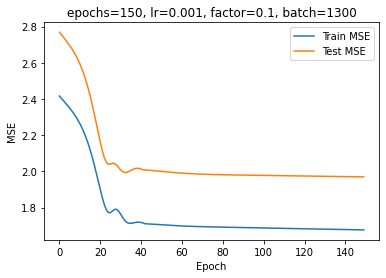

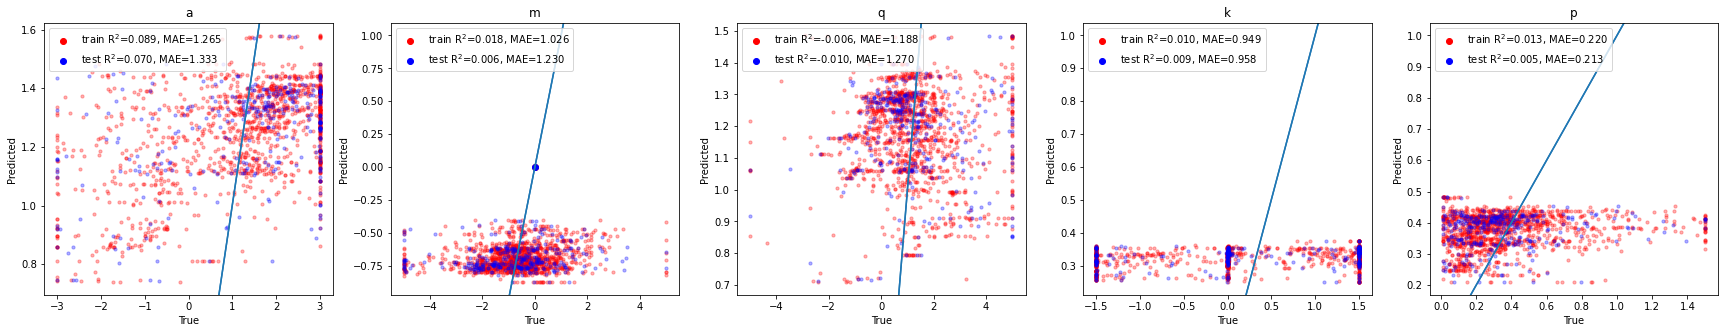

In [53]:
class LinearNet(nn.Module):
    def __init__(self):
        
        super(LinearNet, self).__init__()
        
        self.input = nn.Linear(X_train_torch.shape[1], 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 64)

        self.output = nn.Linear(64, y_train_torch.shape[1])
        
        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
                
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        
        x = self.hidden2(x)
        x = F.relu(x)
        
        x = self.hidden3(x)
        x = F.relu(x)
        
        x = self.output(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = y_train_torch.shape[1], figsize = (y_train_torch.shape[1]*6,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred = model.forward(datax).detach().cpu().numpy()
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred
        
        for i, column in enumerate(df_y.columns):
        
            r2 = r2_score(y_true_norm[:,i], y_pred_norm[:,i])
            mae = mean_absolute_error(y_true_norm[:,i], y_pred_norm[:,i])

            ax[i].axline((1, 1), slope=1)

            ax[i].scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)


            ax[i].scatter(x=y_true_norm[:,i].ravel(), y=y_pred_norm[:,i].ravel(), c=c, alpha=0.3, s=10,
                       )

            ax[i].set_title(f'{column}')
            ax[i].set_xlabel('True')
            ax[i].set_ylabel('Predicted')
            ax[i].legend(loc='upper left')

        #ax.set_xlim([-0.25, 3.5])
        #ax.set_ylim([-0.25, 3.5])
        
## generate models
    
epochs = 150
lr = 0.001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = LinearNet()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
            
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

In [21]:
y_train_torch.shape

torch.Size([1300])

In [125]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nnu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(X_train_torch, y_train_torch.squeeze(1), likelihood).to(device)

# Put the model and likelihood in training mode
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Loss for GPs: the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = -mll(output, y_train_torch.squeeze(1)).sum()
    loss.backward()
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    i + 1, training_iter, loss.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item()
))

    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 2.063   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.977   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 1.927   lengthscale: 0.786   noise: 0.797
Iter 4/50 - Loss: 1.885   lengthscale: 0.825   noise: 0.849
Iter 5/50 - Loss: 1.852   lengthscale: 0.862   noise: 0.902
Iter 6/50 - Loss: 1.842   lengthscale: 0.892   noise: 0.953
Iter 7/50 - Loss: 1.834   lengthscale: 0.918   noise: 1.004
Iter 8/50 - Loss: 1.823   lengthscale: 0.947   noise: 1.053
Iter 9/50 - Loss: 1.820   lengthscale: 0.967   noise: 1.099
Iter 10/50 - Loss: 1.826   lengthscale: 0.984   noise: 1.142
Iter 11/50 - Loss: 1.825   lengthscale: 0.999   noise: 1.182
Iter 12/50 - Loss: 1.830   lengthscale: 1.013   noise: 1.219
Iter 13/50 - Loss: 1.835   lengthscale: 1.025   noise: 1.252
Iter 14/50 - Loss: 1.837   lengthscale: 1.033   noise: 1.283
Iter 15/50 - Loss: 1.832   lengthscale: 1.039   noise: 1.309
Iter 16/50 - Loss: 1.835   lengthscale: 1.047   noise: 1.333
Iter 17/50 - Loss: 1.836   length

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

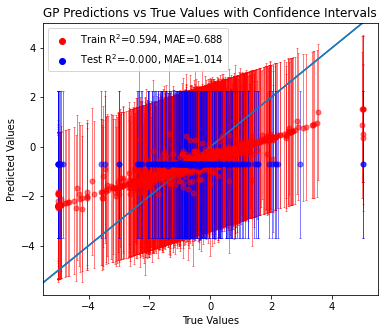

In [126]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_preds = likelihood(model(X_train_torch))
    train_mean = train_preds.mean
    train_lower, train_upper = train_preds.confidence_region()

    test_preds = likelihood(model(X_test_torch))
    test_mean = test_preds.mean
    test_lower, test_upper = test_preds.confidence_region()
    
    
fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

# Plotting with error bars

for true, pred, lower, upper, c, label in zip([y_train_torch, y_test_torch],[train_mean, test_mean],
                                       [train_lower, test_lower], [train_upper, test_upper],
                                       ['r', 'b'], ['Train', 'Test']):
    

    ax.errorbar(true.cpu().numpy(), pred.cpu().numpy(), 
                yerr=[(pred - lower).cpu().numpy(), (upper - pred).cpu().numpy()],
                fmt='o', color=c, markersize=5, elinewidth=1, capsize=1, alpha=0.5)

    ax.axline((1, 1), slope=1)

    r2 = r2_score(true.cpu().numpy(), pred.cpu().numpy())
    mae = mean_absolute_error(true.cpu().numpy(), pred.cpu().numpy())
    ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(label,r2,mae),)


# 3. Add labels, legend, and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GP Predictions vs True Values with Confidence Intervals')
plt.legend()

plt.show()

In [63]:
loss.shape

torch.Size([1504])

0/200, MSE:4.083, time taken: 0.036s
10/200, MSE:3.799, time taken: 0.015s
20/200, MSE:3.363, time taken: 0.013s
30/200, MSE:2.717, time taken: 0.031s
40/200, MSE:2.555, time taken: 0.015s
50/200, MSE:2.333, time taken: 0.016s
60/200, MSE:2.146, time taken: 0.013s
70/200, MSE:2.043, time taken: 0.013s
80/200, MSE:1.964, time taken: 0.014s
90/200, MSE:1.881, time taken: 0.013s
100/200, MSE:1.788, time taken: 0.027s
110/200, MSE:1.688, time taken: 0.013s
120/200, MSE:1.612, time taken: 0.013s
130/200, MSE:1.546, time taken: 0.014s
140/200, MSE:1.481, time taken: 0.017s
150/200, MSE:1.433, time taken: 0.028s
160/200, MSE:1.393, time taken: 0.014s
170/200, MSE:1.358, time taken: 0.014s
180/200, MSE:1.327, time taken: 0.013s
190/200, MSE:1.299, time taken: 0.027s


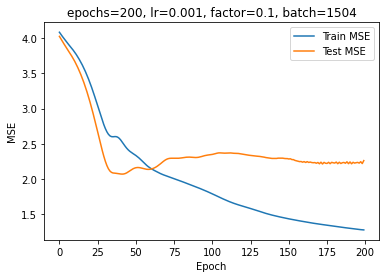

In [43]:
class LinearNet(nn.Module):
    def __init__(self):
        
        super(LinearNet, self).__init__()
        
        self.input = nn.Linear(X_train.shape[1], 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, y_train.shape[1])
        
        #self.dropout = nn.Dropout(p=0.2)

        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
                
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        
        x = self.hidden2(x)        
        x = F.relu(x)
        
        x = self.output(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred = model.forward(datax).detach().cpu().numpy()
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred
        
        r2 = r2_score(y_true_norm, y_pred_norm)
        mae = mean_absolute_error(y_true_norm, y_pred_norm)

        ax.axline((1, 1), slope=1)

        ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)


        ax.scatter(x=y_true_norm.ravel(), y=y_pred_norm.ravel(), c=c, alpha=0.3, s=10,
                   )

        ax.set_title(f'a')
        ax.set_xlabel('True')
        ax.set_ylabel('Predicted')
        ax.legend(loc='upper left')

        #ax.set_xlim([-0.25, 3.5])
        #ax.set_ylim([-0.25, 3.5])
        
## generate models
    
epochs = 200
lr = 0.001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = LinearNet()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
            
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

In [52]:
df_y.columns

Index(['a', 'm', 'q', 'k', 'p'], dtype='object')

<AxesSubplot:ylabel='Frequency'>

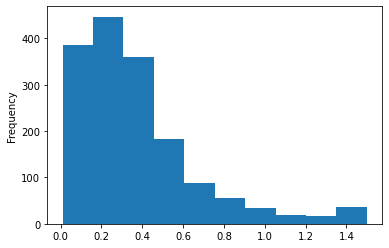

In [56]:
df_y['p'].plot.hist()

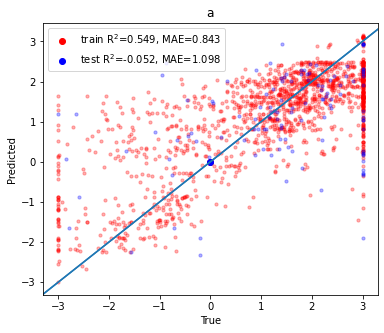

In [47]:
X_train.shape, y_train.shape

((1504, 67), (1504, 1))

(-0.25, 3.5)

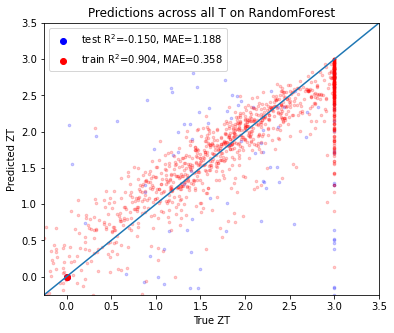

In [49]:
model = RandomForestRegressor(n_estimators=500,max_depth=None,min_samples_split=2,
                              random_state=42)
model.fit(X_train, y_train.ravel())


fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

ax.axline((1, 1), slope=1)

for split, datax, datay, c in zip(['test', 'train'],
                                  [X_test, X_train],
                                  [y_test, y_train],
                                  ['b', 'r']):
    
    y_pred = model.predict(datax)

    r2 = r2_score(datay, y_pred)
    mae = mean_absolute_error(datay, y_pred)

    ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

    ax.scatter(x=datay.ravel(), y=y_pred.ravel(), c=c, alpha=0.2, s=7,
               )

ax.set_title(f'Predictions across all T on RandomForest')
ax.set_xlabel('True ZT')
ax.set_ylabel('Predicted ZT')
ax.legend(loc='upper left')

ax.set_xlim([-0.25, 3.5])
ax.set_ylim([-0.25, 3.5])

In [26]:
# Function to generate formula
def compile_formula(row):
    formula = ''
    for col in df_elem.columns:
        if row[col] > 0:
            formula += col
            # Always append the numeric value
            formula += str(row[col])
    return formula

formula = pd.DataFrame(df_elem.apply(compile_formula, axis=1))
formula = formula.rename(columns={0: "formula"})
formula['target'] = 0

df_magpie, _, _, _ = generate_features(formula, elem_prop='Magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
df_magpie

Processing Input Data: 100%|████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 21181.64it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 13766.75it/s]


	Creating Pandas Objects...


,sum_Number,sum_MendeleevNumber,sum_AtomicWeight,sum_MeltingT,sum_Column,sum_Row,sum_CovalentRadius,sum_Electronegativity,sum_NsValence,sum_NpValence,...,mode_NValence,mode_NsUnfilled,mode_NpUnfilled,mode_NdUnfilled,mode_NfUnfilled,mode_NUnfilled,mode_GSvolume_pa,mode_GSbandgap,mode_GSmagmom,mode_SpaceGroupNumber
0,18.88600,68.51800,40.180062,1665.016000,11.43400,3.40000,121.60600,1.787180,2.00000,1.27200,...,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0
1,55.36000,86.68000,135.812896,527.418000,15.36000,4.88000,131.92000,2.378800,2.00000,3.36000,...,16.0,0.0,2.0,0.0,0.0,2.0,25.920000,0.799,0.000000,14.0
2,28.06103,78.50485,64.345381,326.935956,13.99939,3.50545,105.15105,2.564676,1.99849,1.99600,...,6.0,0.0,0.0,0.0,0.0,0.0,9.105000,0.000,0.000000,12.0
3,18.18514,72.91930,37.785094,907.740557,11.98882,3.34310,123.42990,2.230477,1.99262,2.64800,...,6.0,0.0,2.0,0.0,0.0,2.0,25.786875,2.202,0.000000,70.0
4,39.01095,75.81025,89.565544,784.261210,13.27635,4.42925,129.30625,1.821350,1.99685,1.28100,...,12.0,0.0,0.0,0.0,0.0,0.0,13.960000,0.000,0.000000,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,40.77000,65.41000,93.686414,1519.512000,10.17000,4.70000,145.36000,1.791100,2.00000,1.20000,...,15.0,0.0,3.0,0.0,0.0,3.0,31.560000,0.000,0.000000,166.0
1622,40.78000,65.44000,93.684016,1519.112000,10.18000,4.70000,145.34000,1.791400,2.00000,1.20000,...,15.0,0.0,3.0,0.0,0.0,3.0,31.560000,0.000,0.000000,166.0
1623,39.01000,61.70700,88.644839,1463.924840,9.36400,4.65000,145.44200,1.740720,2.00200,0.64600,...,10.0,0.0,0.0,2.0,0.0,2.0,10.320000,0.000,0.595395,225.0
1624,49.97939,61.97638,118.992619,1484.118362,9.33095,4.99698,148.23784,1.854857,1.99866,0.66899,...,4.0,0.0,0.0,2.0,0.0,2.0,10.320000,0.000,0.000000,194.0


In [27]:
# Get list of columns (element names), except the last formula column
elements = df_elem.columns
grouping = df_elem.apply(lambda row: ''.join(sorted([elem for elem, val in zip(elements, row) if val != 0])), axis=1)
grouping = pd.DataFrame(grouping)
grouping = grouping.rename(columns={0: "grouping"})
grouping

,grouping
0,MnSiW
1,BiPbSe
2,AgCdO
3,AgSTi
4,AgSbZn
...,...
1621,CoNiSbZr
1622,CoNiSbZr
1623,NiSnZr
1624,BiNiPbZr


In [28]:
df_all = pd.concat([df_elem, df_magpie, df_y, grouping], axis=1)
df_all

,Mn,W,Si,Pb,Bi,Se,Ag,Cd,O,Ti,...,mode_GSvolume_pa,mode_GSbandgap,mode_GSmagmom,mode_SpaceGroupNumber,a,m,q,k,p,grouping
0,0.346,0.018,0.636,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,20.440000,0.773,0.000000,227.0,3.000000,-0.148813,2.201553,-0.686747,0.274051,MnSiW
1,0.000,0.000,0.000,0.200,0.24000,0.56,0.00000,0.000,0.000,0.000,...,25.920000,0.799,0.000000,14.0,1.756754,0.076774,1.968316,0.003851,0.351764,BiPbSe
2,0.000,0.000,0.000,0.000,0.00000,0.00,0.00249,0.499,0.499,0.000,...,9.105000,0.000,0.000000,12.0,-0.333947,1.202546,2.752054,-1.500000,0.285028,AgCdO
3,0.000,0.000,0.000,0.000,0.00000,0.00,0.00662,0.000,0.000,0.331,...,25.786875,2.202,0.000000,70.0,1.276173,-0.740363,4.999998,1.500000,0.037586,AgSTi
4,0.000,0.000,0.000,0.000,0.00000,0.00,0.00285,0.000,0.000,0.000,...,13.960000,0.000,0.000000,194.0,3.000000,-0.496756,1.060722,-1.116145,0.461106,AgSbZn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,31.560000,0.000,0.000000,166.0,-0.420817,-0.083924,1.186997,-0.002689,0.227364,CoNiSbZr
1622,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,31.560000,0.000,0.000000,166.0,0.697107,0.975113,0.791262,1.500000,0.229938,CoNiSbZr
1623,0.000,0.000,0.000,0.000,0.00000,0.00,0.00000,0.000,0.000,0.000,...,10.320000,0.000,0.595395,225.0,3.000000,0.834416,2.900146,-0.604342,0.211997,NiSnZr
1624,0.000,0.000,0.000,0.331,0.00233,0.00,0.00000,0.000,0.000,0.000,...,10.320000,0.000,0.000000,194.0,1.147727,-0.777356,0.769663,-0.000661,0.321004,BiNiPbZr


In [35]:
# train-test split, manually by grouping
xtrain_dfs, xtest_dfs, ytrain_dfs, ytest_dfs = [], [], [], []
test_size = 0.1
    
for _, group in df_all.groupby('grouping'):
    if np.random.rand(1) > test_size:
        xtrain_dfs.append(group.iloc[:,:67+154])
        ytrain_dfs.append(group.iloc[:,67+154:-1])
    else:
        xtest_dfs.append(group.iloc[:,:67+154])
        ytest_dfs.append(group.iloc[:,67+154:-1])

xtrain_df = pd.concat(xtrain_dfs, ignore_index=True)
xtest_df = pd.concat(xtest_dfs, ignore_index=True)
ytrain_df = pd.concat(ytrain_dfs, ignore_index=True)
ytest_df = pd.concat(ytest_dfs, ignore_index=True)

# for scikit regressors
X_train = xtrain_df.to_numpy()
X_test = xtest_df.to_numpy()
y_train = ytrain_df.to_numpy()
y_test = ytest_df.to_numpy()

# for pytorch regressors
device = torch.device('cuda:0')
#device = torch.device('cpu')

X_train_torch = Variable(torch.tensor(X_train.astype('float32'), device=device))
X_test_torch = Variable(torch.tensor(X_test.astype('float32'), device=device))
y_train_torch = Variable(torch.tensor(y_train.astype('float32'), device=device))
y_test_torch = Variable(torch.tensor(y_test.astype('float32'), device=device))

## Model training

In [38]:
X_train_torch.shape, y_train_torch.shape

(torch.Size([1483, 221]), torch.Size([1483, 5]))

In [42]:
class LinearNet(nn.Module):
    def __init__(self):
        
        super(LinearNet, self).__init__()
        
        self.input = nn.Linear(X_train.shape[1], 512)
        self.hidden1 = nn.Linear(512, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, y_train.shape[1])
        
        #self.dropout = nn.Dropout(p=0.2)

        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
                
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        #x = self.dropout(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        
        x = self.hidden2(x)        
        x = F.relu(x)
        
        x = self.hidden3(x)        
        x = F.relu(x)
        
        x = self.output(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")

0/100, MSE:6.522, time taken: 0.075s
10/100, MSE:2.026, time taken: 0.012s
20/100, MSE:1.736, time taken: 0.011s
30/100, MSE:1.630, time taken: 0.012s
40/100, MSE:1.575, time taken: 0.012s
50/100, MSE:1.542, time taken: 0.012s
60/100, MSE:1.515, time taken: 0.013s
70/100, MSE:1.493, time taken: 0.011s
80/100, MSE:1.473, time taken: 0.011s
90/100, MSE:1.456, time taken: 0.012s


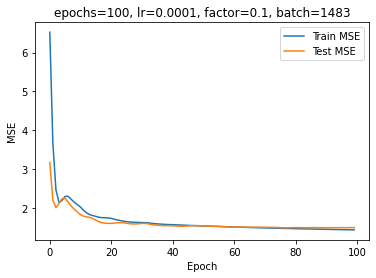

In [43]:
## generate models
    
epochs = 100
lr = 0.0001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = LinearNet()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()

In [44]:
y_test_torch.shape

torch.Size([143, 5])

In [47]:
df_y.columns

Index(['a', 'm', 'q', 'k', 'p'], dtype='object')

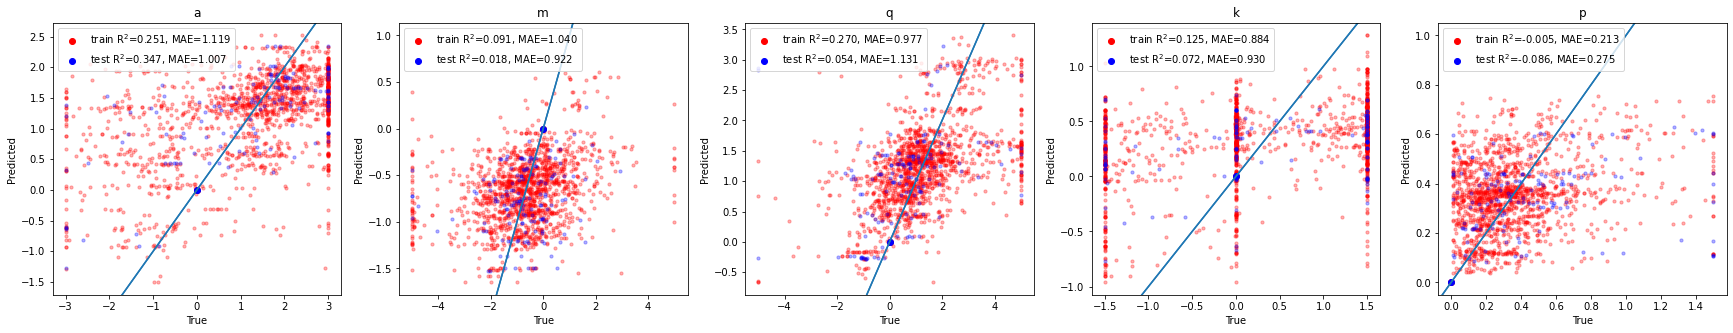

In [49]:
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = 5, figsize = (30,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred = model.forward(datax).detach().cpu().numpy()
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred
        
        for i in range(0,ytrain.shape[1]): 

            r2 = r2_score(y_true_norm[:,i], y_pred_norm[:,i])
            mae = mean_absolute_error(y_true_norm[:,i], y_pred_norm[:,i])

            ax[i].axline((1, 1), slope=1)

            ax[i].scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

        
            ax[i].scatter(x=y_true_norm[:,i].ravel(), y=y_pred_norm[:,i].ravel(), c=c, alpha=0.3, s=10,
                       )

            ax[i].set_title(f'{df_y.columns[i]}')
            ax[i].set_xlabel('True')
            ax[i].set_ylabel('Predicted')
            ax[i].legend(loc='upper left')
            
            #ax.set_xlim([-0.25, 3.5])
            #ax.set_ylim([-0.25, 3.5])
            
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

In [36]:
class LinearNet(nn.Module):
    def __init__(self):
        
        super(LinearNet, self).__init__()
        
        self.input = nn.Linear(X_train.shape[1], 512)
        self.hidden1 = nn.Linear(512, 512)
        self.hidden2 = nn.Linear(512, 512)
        self.hidden3 = nn.Linear(512, 512)
        self.hidden4 = nn.Linear(512, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(64, y_train.shape[1])
        
        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
                
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        #x = self.dropout(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        
        x = self.hidden2(x)        
        x = F.relu(x)
        
        x = self.hidden3(x)        
        x = F.relu(x)
        
        x = self.hidden4(x)        
        x = F.relu(x)
        
        x = self.output(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        
        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
        
        # Encoder
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(32)  # BatchNorm layer after conv1
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)  # BatchNorm layer after conv2
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1, batch_first=True)
        
        # Decoder, takes (size of convolution channels) * (number of variables) * 2, I'm not sure why
        self.deconv1 = nn.Linear(in_features=64*221*2, out_features=512)
        self.deconv1_bn = nn.BatchNorm1d(512)  # BatchNorm layer for decoder
        self.deconv2 = nn.Linear(in_features=512, out_features=128)
        self.deconv3 = nn.Linear(in_features=128, out_features=21)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x, _ = self.lstm(x.transpose(1, 2))  # Transpose to have seq_len as the second dimension
        x = x.transpose(1, 2)  # Transpose back to original shape

        # Flatten x before Decoder
        x = x.reshape(x.size(0), -1)

        # Decoder
        x = self.deconv1(x)
        x = self.deconv1_bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.deconv3(x)
        x = self.relu(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        
        
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred = model.forward(datax).detach().cpu().numpy()
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred

        r2 = r2_score(y_true_norm, y_pred_norm)
        mae = mean_absolute_error(y_true_norm, y_pred_norm)

        ax.axline((1, 1), slope=1)

        ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

        for i in range(0,ytrain.shape[1]):

            ax.scatter(x=y_true_norm[:,i].ravel(), y=y_pred_norm[:,i].ravel(), c=c, alpha=0.3, s=10,
                       )

            ax.set_title(f'Predictions across all T')
            ax.set_xlabel('True ZT')
            ax.set_ylabel('Predicted ZT')
            ax.legend(loc='upper left')
            
            ax.set_xlim([-0.25, 3.5])
            ax.set_ylim([-0.25, 3.5])

    fig, ax = plt.subplots(ncols = 1, figsize = (6,5))


    for split, datax, datay, c in zip(['train', 'test'],
                                          [xtrain, xtest],
                                          [ytrain, ytest],
                                          ['r', 'b']):


            model.eval()

            y_true = datay.cpu().numpy()
            y_pred = nnmodel.forward(datax).detach().cpu().numpy()
            
            #y_pred = np.clip(y_pred, -2.2, 2.2)
            #y_true_norm = yscaler.inverse_transform(y_true)
            #y_pred_norm = yscaler.inverse_transform(y_pred)

            y_true_norm = y_true
            y_pred_norm = y_pred

            for i, temp in enumerate(temprange):

                r2 = r2_score(y_true_norm[:,i], y_pred_norm[:,i])

                ax.scatter(x=temp, y=r2, c=c, alpha=0.3,
                            label='{:}'.format(split), 
                           )

    ax.set_title(f'Model Accuracy')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('R2 score')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    #ax.legend(loc='upper left')

0/100, MSE:4.594, time taken: 4.078s
10/100, MSE:1.881, time taken: 0.017s
20/100, MSE:1.771, time taken: 0.015s
30/100, MSE:1.670, time taken: 0.015s
40/100, MSE:1.608, time taken: 0.015s
50/100, MSE:1.582, time taken: 0.016s
60/100, MSE:1.541, time taken: 0.014s
70/100, MSE:1.541, time taken: 0.015s
80/100, MSE:1.489, time taken: 0.015s
90/100, MSE:1.463, time taken: 0.016s


NameError: name 'temprange' is not defined

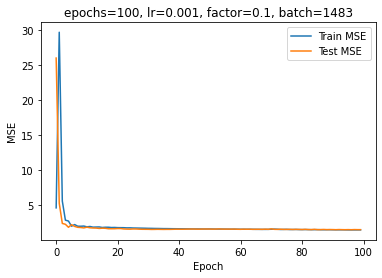

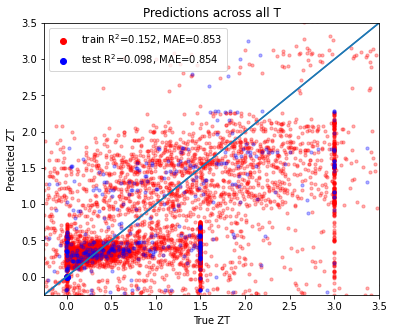

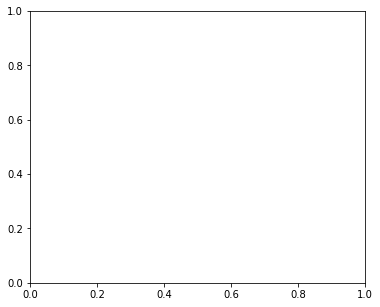

In [37]:
## generate models
    
epochs = 100
lr = 0.001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = LinearNet()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

0/50, MSE:0.237, time taken: 7.119s
10/50, MSE:0.149, time taken: 8.245s
20/50, MSE:0.125, time taken: 8.162s
30/50, MSE:0.118, time taken: 7.787s
40/50, MSE:0.104, time taken: 7.780s


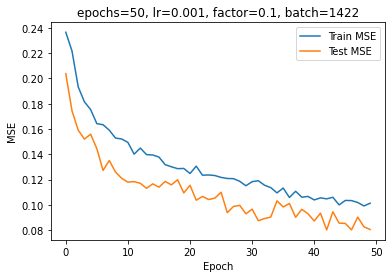

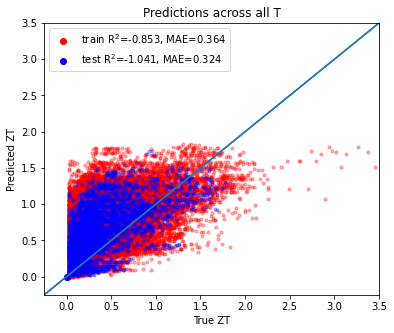

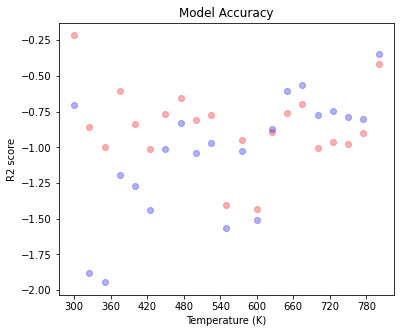

In [37]:
## generate models
    
epochs = 50
lr = 0.001
factor = 0.1
patience = 5
batchsize = int(len(X_train_torch))
    
torch.manual_seed(1)
nnmodel = CNN_LSTM()
nnmodel.to(torch.device('cpu'))
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

0/100, MSE:0.254, time taken: 0.366s
10/100, MSE:0.145, time taken: 0.215s
20/100, MSE:0.124, time taken: 0.212s
30/100, MSE:0.113, time taken: 0.214s
40/100, MSE:0.106, time taken: 0.212s
50/100, MSE:0.098, time taken: 0.213s
60/100, MSE:0.096, time taken: 0.213s
70/100, MSE:0.096, time taken: 0.215s
80/100, MSE:0.092, time taken: 0.212s
90/100, MSE:0.093, time taken: 0.215s


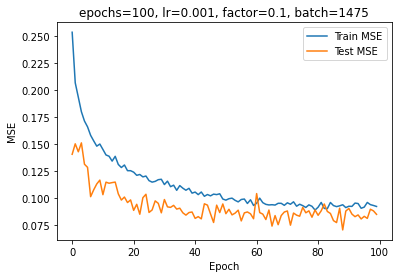

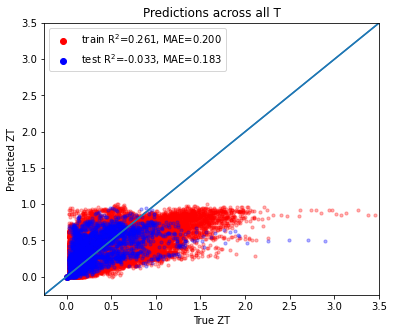

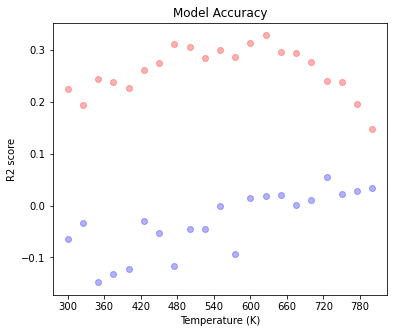

In [74]:
## generate models
    
epochs = 100
lr = 0.001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = ConvAutoencoder()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

In [75]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        
        self.input = nn.Linear(X_train.shape[1], 512)
        self.hidden1 = nn.Linear(512, 512)
        self.hidden2 = nn.Linear(512, 512)
        self.hidden3 = nn.Linear(512, 512)
        self.hidden4 = nn.Linear(512, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.output = nn.Linear(64, y_train.shape[1])
        
        self.losscurvetrain = []
        self.losscurvetest = []
        
        self.lr = 0.01
        self.epochs = 200
        self.factor = 0.5
        self.batchsize = 64
                
    def forward(self, x):
        
        x = self.input(x)
        x = F.relu(x)
        
        #x = self.dropout(x)
        
        x = self.hidden1(x)
        x = F.relu(x)
        
        x = self.hidden2(x)        
        x = F.relu(x)
        
        x = self.hidden3(x)        
        x = F.relu(x)
        
        x = self.hidden4(x)        
        x = F.relu(x)
        
        x = self.output(x)
        
        return x
    
    def fit(self, xtrain, ytrain, xtest, ytest, epochs=200, batchsize=64, lr=0.01, factor=0.5, patience=5, verbose=True):
       
        self.epochs = epochs
        self.lr = lr
        self.factor = factor
        self.batchsize = batchsize
        self.patience = patience
        
        dataloader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batchsize, shuffle=True)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=1e-5)
        loss_func = nn.MSELoss()
        scheduler = ReduceLROnPlateau(optimizer, factor=factor, patience=patience, mode='min')
      
        for t in range(epochs):
            
            t0 = time()
            
            batch_loss = []
            for x_batch, y_batch in dataloader:
                
                pred = self.forward(x_batch)     
                loss = loss_func(pred, y_batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                
                batch_loss.append(loss.item())
                
            y_pred = self.forward(xtest)
            testloss = loss_func(y_pred, ytest)
            
            self.losscurvetrain.append(np.array(batch_loss).mean().item())
            self.losscurvetest.append(testloss.item())
            
            if verbose:
                if t%10==0:
                    print(f"{t}/{epochs}, MSE:{np.array(batch_loss).mean().item():.3f}, time taken: {time()-t0:.3f}s")
            
    def plot_losscurve(self):
        plt.plot(np.arange(0,self.epochs), self.losscurvetrain, label=f"Train MSE")
        plt.plot(np.arange(0,self.epochs), self.losscurvetest, label=f"Test MSE")
        plt.legend()
        plt.title(f"epochs={self.epochs}, lr={self.lr}, factor={self.factor}, batch={self.batchsize}")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        
def plot_predictions(model, xtrain, xtest, ytrain, ytest):
    fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

    for split, datax, datay, c in zip(['train', 'test'],
                                      [xtrain, xtest],
                                      [ytrain, ytest],
                                      ['r', 'b']):

        model.eval()

        y_true = datay.cpu().numpy()
        y_pred = model.forward(datax).detach().cpu().numpy()
        
        #y_pred = np.clip(y_pred, -2.2, 2.2)
        #y_true_norm = yscaler.inverse_transform(y_true)
        #y_pred_norm = yscaler.inverse_transform(y_pred)
        
        y_true_norm = y_true
        y_pred_norm = y_pred

        r2 = r2_score(y_true_norm, y_pred_norm)
        mae = mean_absolute_error(y_true_norm, y_pred_norm)

        ax.axline((1, 1), slope=1)

        ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

        for i in range(0,ytrain.shape[1]):

            ax.scatter(x=y_true_norm[:,i].ravel(), y=y_pred_norm[:,i].ravel(), c=c, alpha=0.3, s=10,
                       )

            ax.set_title(f'Predictions across all T')
            ax.set_xlabel('True ZT')
            ax.set_ylabel('Predicted ZT')
            ax.legend(loc='upper left')
            
            ax.set_xlim([-0.25, 3.5])
            ax.set_ylim([-0.25, 3.5])

    fig, ax = plt.subplots(ncols = 1, figsize = (6,5))


    for split, datax, datay, c in zip(['train', 'test'],
                                          [xtrain, xtest],
                                          [ytrain, ytest],
                                          ['r', 'b']):


            model.eval()

            y_true = datay.cpu().numpy()
            y_pred = nnmodel.forward(datax).detach().cpu().numpy()
            
            #y_pred = np.clip(y_pred, -2.2, 2.2)
            #y_true_norm = yscaler.inverse_transform(y_true)
            #y_pred_norm = yscaler.inverse_transform(y_pred)

            y_true_norm = y_true
            y_pred_norm = y_pred

            for i, temp in enumerate(temprange):

                r2 = r2_score(y_true_norm[:,i], y_pred_norm[:,i])

                ax.scatter(x=temp, y=r2, c=c, alpha=0.3,
                            label='{:}'.format(split), 
                           )

    ax.set_title(f'Model Accuracy')
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('R2 score')
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    
    #ax.legend(loc='upper left')

0/150, MSE:1.669, time taken: 0.101s
10/150, MSE:0.598, time taken: 0.028s
20/150, MSE:0.359, time taken: 0.026s
30/150, MSE:0.255, time taken: 0.026s
40/150, MSE:0.192, time taken: 0.028s
50/150, MSE:0.162, time taken: 0.026s
60/150, MSE:0.146, time taken: 0.028s
70/150, MSE:0.135, time taken: 0.028s
80/150, MSE:0.126, time taken: 0.029s
90/150, MSE:0.120, time taken: 0.031s
100/150, MSE:0.115, time taken: 0.027s
110/150, MSE:0.111, time taken: 0.260s
120/150, MSE:0.108, time taken: 0.028s
130/150, MSE:0.106, time taken: 0.026s
140/150, MSE:0.103, time taken: 0.029s


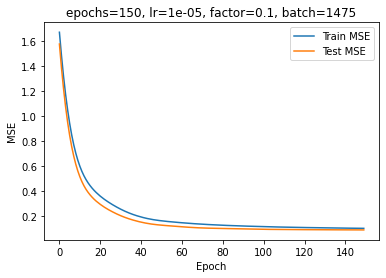

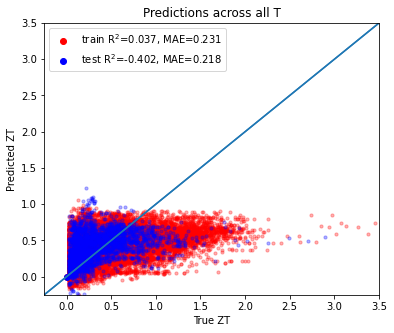

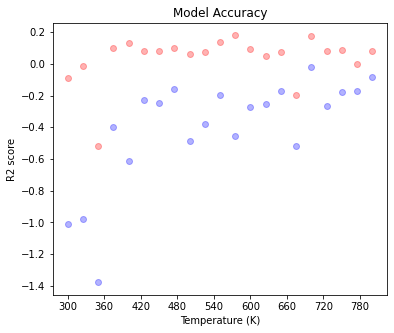

In [76]:
## generate models
    
epochs = 150
lr = 0.00001
factor = 0.1
patience = 5
batchsize = len(X_train_torch)
    
torch.manual_seed(1)
nnmodel = Net()
nnmodel.to(device)
nnmodel.fit(X_train_torch, y_train_torch, X_test_torch, y_test_torch,
            epochs=epochs, batchsize=batchsize, lr=lr, factor=factor, patience=patience, verbose=True)  

nnmodel.plot_losscurve()
plot_predictions(nnmodel, X_train_torch, X_test_torch, y_train_torch, y_test_torch)

(-0.25, 3.5)

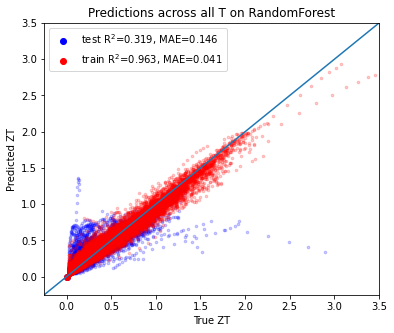

In [77]:
model = RandomForestRegressor(n_estimators=100,max_depth=None,min_samples_split=2,
                              random_state=42)
model.fit(X_train, y_train)


fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

ax.axline((1, 1), slope=1)

for split, datax, datay, c in zip(['test', 'train'],
                                  [X_test, X_train],
                                  [y_test, y_train],
                                  ['b', 'r']):
    
    y_pred = model.predict(datax)

    r2 = r2_score(datay, y_pred)
    mae = mean_absolute_error(datay, y_pred)

    ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

    for i in range(0,y_train.shape[1]):

        ax.scatter(x=datay[:,i].ravel(), y=y_pred[:,i].ravel(), c=c, alpha=0.2, s=7,
                   )

ax.set_title(f'Predictions across all T on RandomForest')
ax.set_xlabel('True ZT')
ax.set_ylabel('Predicted ZT')
ax.legend(loc='upper left')

ax.set_xlim([-0.25, 3.5])
ax.set_ylim([-0.25, 3.5])

(-0.25, 3.5)

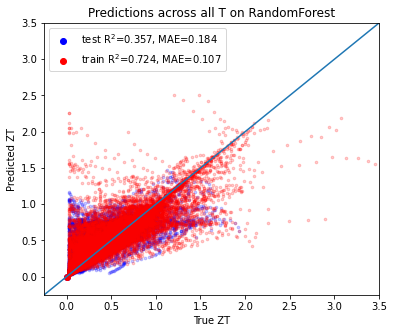

In [35]:
from sklearn.multioutput import RegressorChain
from sklearn.svm import LinearSVR

# define base model
innermodel = RandomForestRegressor()
# define the chained multioutput wrapper model
model = RegressorChain(innermodel)

model.fit(X_train, y_train)

fig, ax = plt.subplots(ncols = 1, figsize = (6,5))

ax.axline((1, 1), slope=1)

for split, datax, datay, c in zip(['test', 'train'],
                                  [X_test, X_train],
                                  [y_test, y_train],
                                  ['b', 'r']):
    
    y_pred = model.predict(datax)

    r2 = r2_score(datay, y_pred)
    mae = mean_absolute_error(datay, y_pred)

    ax.scatter(0,0, c=c, alpha=1, label='{:} R$^2$={:.3f}, MAE={:.3f}'.format(split,r2,mae),)

    for i in range(0,y_train.shape[1]):

        ax.scatter(x=datay[:,i].ravel(), y=y_pred[:,i].ravel(), c=c, alpha=0.2, s=7,
                   )

ax.set_title(f'Predictions across all T on RandomForest')
ax.set_xlabel('True ZT')
ax.set_ylabel('Predicted ZT')
ax.legend(loc='upper left')

ax.set_xlim([-0.25, 3.5])
ax.set_ylim([-0.25, 3.5])